# Daily Analysis of Stores and Transactions

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns

In [3]:
#Dask is used for reading the csv. When I was using pandas in the other projects sometimes pandas cannot read all of the data. For that reason I prefer to use dask.
sales_df = dd.read_csv("transactions.csv")
sales_df = sales_df.compute()
sales_df

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

## Store-Based

In [4]:
sales_df.drop(index=0,inplace=True)
sales_df["date"] = pd.to_datetime(sales_df["date"]) #Converting date column to datetime format

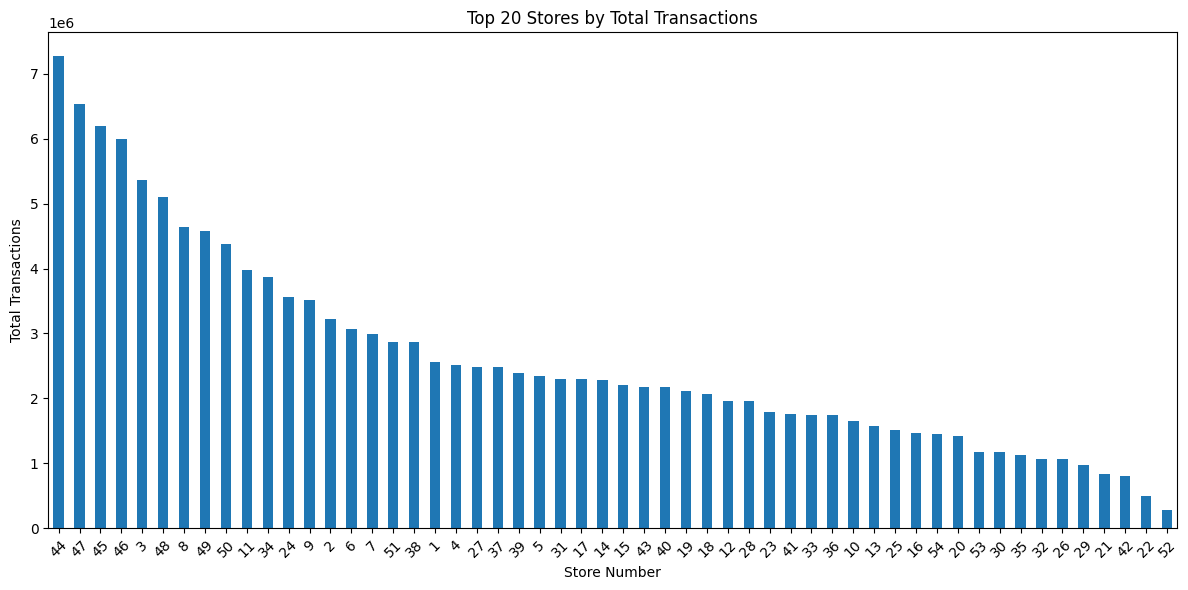

In [9]:
# 1. Top 20 stores with the highest total transactions
top_stores = sales_df.groupby('store_nbr')['transactions'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
top_stores.plot(kind='bar')
plt.title('Top 20 Stores by Total Transactions')
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
unique_stores = sales_df['store_nbr'].unique()
unique_stores.sort()
group_size = 10
num_groups = len(unique_stores) // group_size + (len(unique_stores) % group_size > 0)

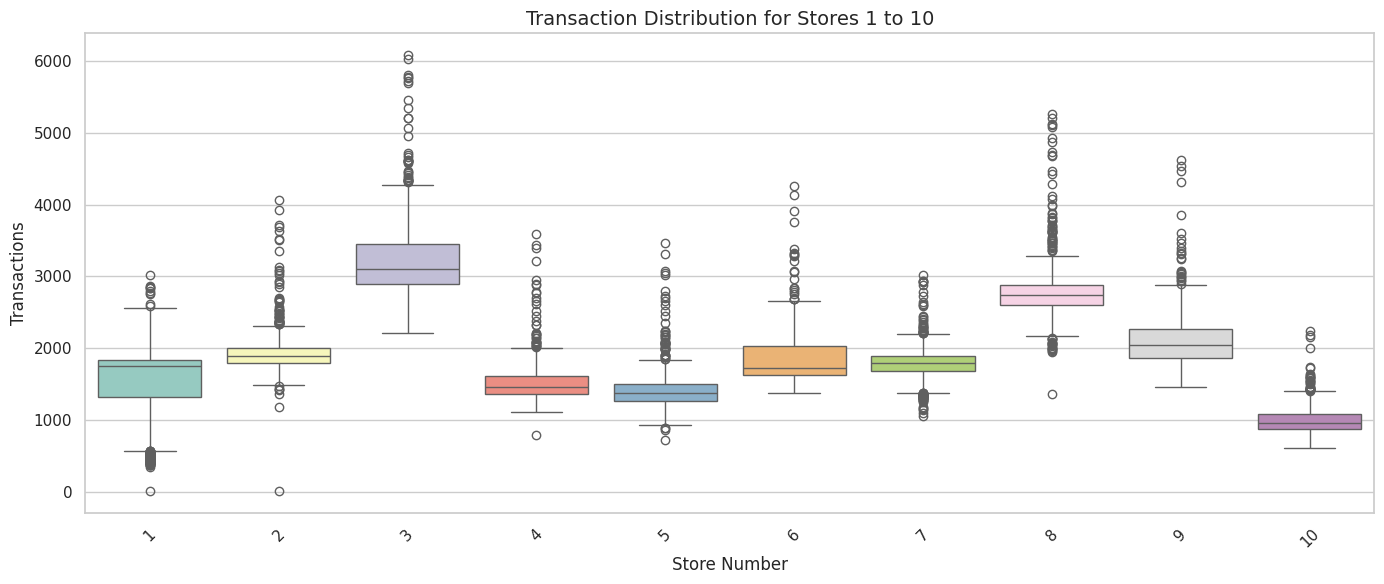

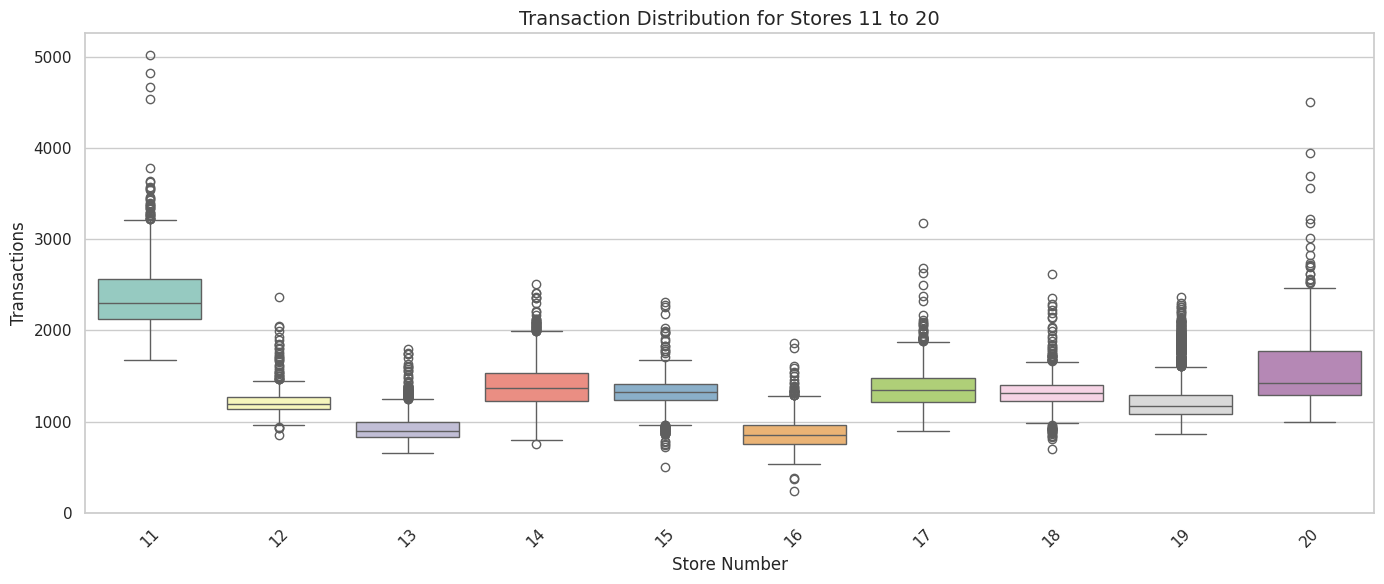

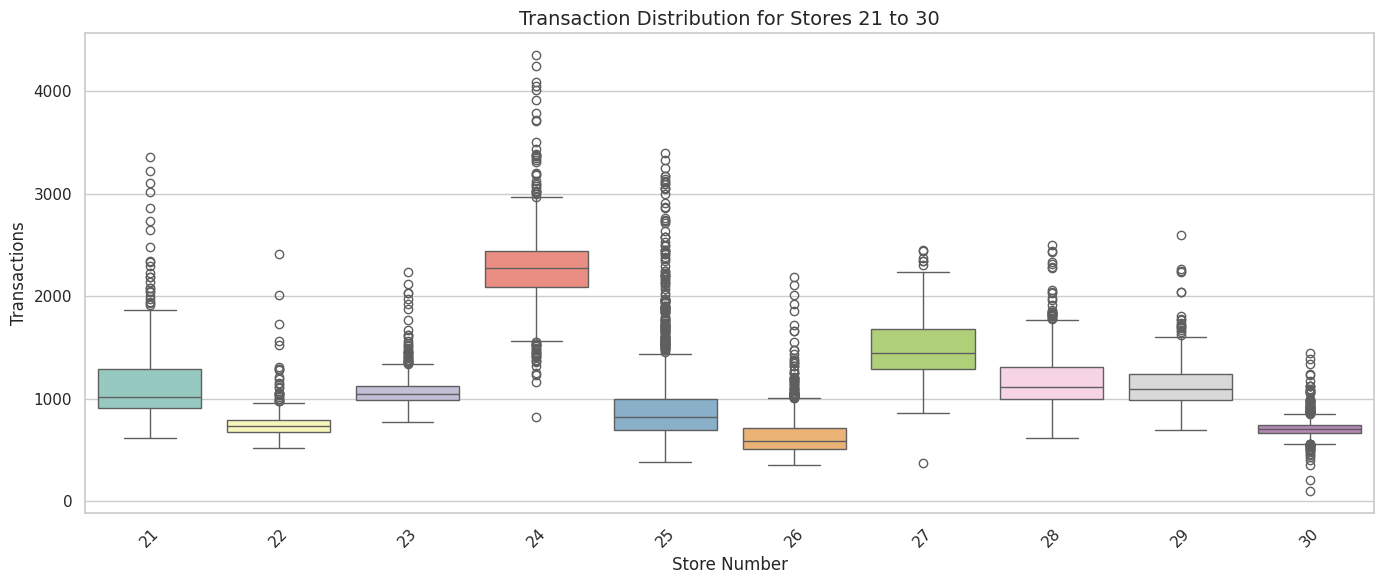

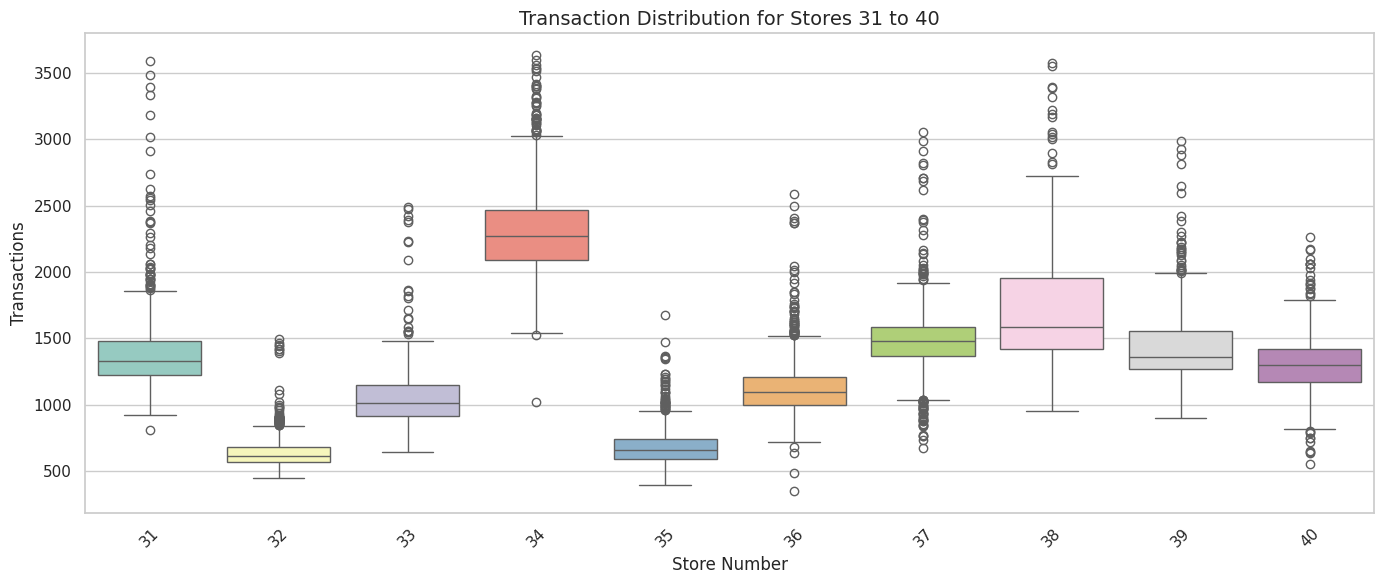

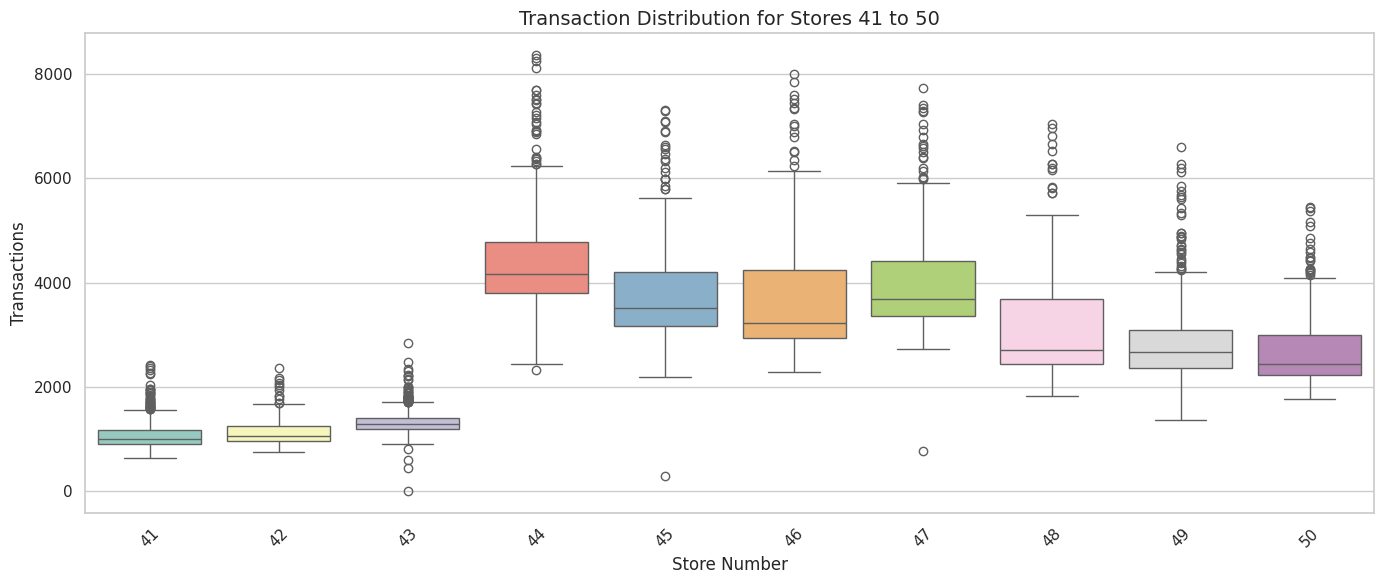

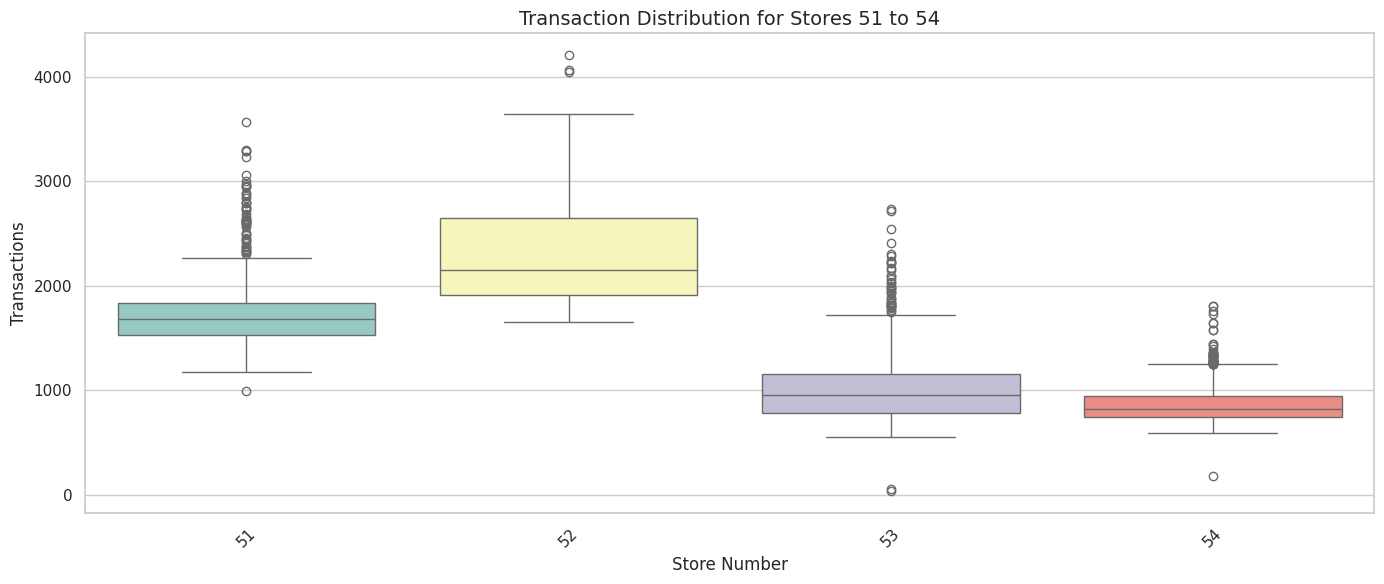

In [19]:
sns.set(style="whitegrid")
for i in range(num_groups):
    group_stores = unique_stores[i*group_size : (i+1)*group_size]
    group_data = sales_df[sales_df['store_nbr'].isin(group_stores)]

    plt.figure(figsize=(14, 6))
    ax = sns.boxplot(data=group_data, x='store_nbr', y='transactions', palette="Set3")

    plt.title(f'Transaction Distribution for Stores {group_stores[0]} to {group_stores[-1]}', fontsize=14)
    plt.xlabel('Store Number', fontsize=12)
    plt.ylabel('Transactions', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [31]:
import plotly.express as px

for i in range(num_groups):
    group_stores = unique_stores[i*group_size : (i+1)*group_size]
    group_data = sales_df[sales_df['store_nbr'].isin(group_stores)]

    fig = px.box(group_data,
                 x='store_nbr',
                 y='transactions',
                 color='store_nbr',
                 points="outliers",  # or "all"
                 title=f"Transaction Distribution for Stores {group_stores[0]} to {group_stores[-1]}")

    fig.update_layout(xaxis_title="Store Number",
                      yaxis_title="Transactions",
                      template="plotly_white",
                      height=600,
                      showlegend=False)

    fig.show()

In [29]:
import plotly.graph_objects as go

store_list = sales_df['store_nbr'].unique()

for store in store_list:
    store_data = sales_df[sales_df['store_nbr'] == store]
    store_daily = store_data.groupby('date')['transactions'].sum()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=store_daily.index, y=store_daily.values,
                             mode='lines+markers',
                             name=f'Store {store}'))

    fig.update_layout(title=f'Daily Transactions - Store {store}',
                      xaxis_title='Date',
                      yaxis_title='Transactions',
                      template='plotly_white',
                      height=500)
    fig.show()

In [33]:

store_stats = sales_df.groupby("store_nbr")["transactions"].agg(['mean', 'std']).reset_index()


fig = px.scatter(store_stats,
                 x="mean",
                 y="std",
                 text="store_nbr",
                 hover_name="store_nbr",
                 labels={"mean": "Average Transactions", "std": "Standard Deviation"},
                 title="Store Performance: Mean vs Std of Transactions")

fig.update_traces(marker=dict(size=10, color='blue', opacity=0.7),
                  textposition='top center')

fig.update_layout(template="plotly_white",
                  height=700,
                  width=1000,
                  xaxis_title="Average Transactions",
                  yaxis_title="Transaction Std Dev",
                  showlegend=False)

fig.show()

In [35]:

store_activity = sales_df.groupby('store_nbr').agg(
    total_sales=('transactions', 'sum'),
    active_days=('date', 'nunique')
).reset_index()


store_activity['avg_sales_per_day'] = store_activity['total_sales'] / store_activity['active_days']


fig = px.bar(store_activity,
             x='store_nbr',
             y='avg_sales_per_day',
             hover_data=['total_sales', 'active_days'],
             title='Average Sales per Active Day by Store',
             labels={'store_nbr': 'Store', 'avg_sales_per_day': 'Avg Transactions per Active Day'},
             template='plotly_white')

fig.update_layout(height=600, width=1000, xaxis={'categoryorder':'total descending'})
fig.show()

# GRUP

In [5]:
group_sales = sales_df.groupby("date",as_index=False).agg({"transactions":"sum"})
group_sales

date  transactions
0    2013-01-02         93215
1    2013-01-03         78504
2    2013-01-04         78494
3    2013-01-05         93573
4    2013-01-06         90464
...         ...           ...
1676 2017-08-11         89551
1677 2017-08-12         89927
1678 2017-08-13         85993
1679 2017-08-14         85448
1680 2017-08-15         86561

[1681 rows x 2 columns]

In [14]:
values = group_sales['transactions']

# Calculate Q1, Q3, and IQR
Q1 = np.percentile(values, 25)
Q3 = np.percentile(values, 75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = values[(values < lower_bound) | (values > upper_bound)]
print("Total number of outliers:", len(outliers))

Total number of outliers: 40


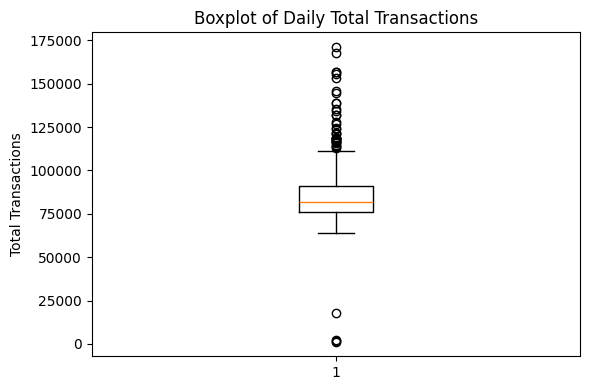

In [13]:
plt.figure(figsize=(6,4))
plt.boxplot(group_sales['transactions'].values)
plt.title('Boxplot of Daily Total Transactions')
plt.ylabel('Total Transactions')
plt.tight_layout()
plt.show()

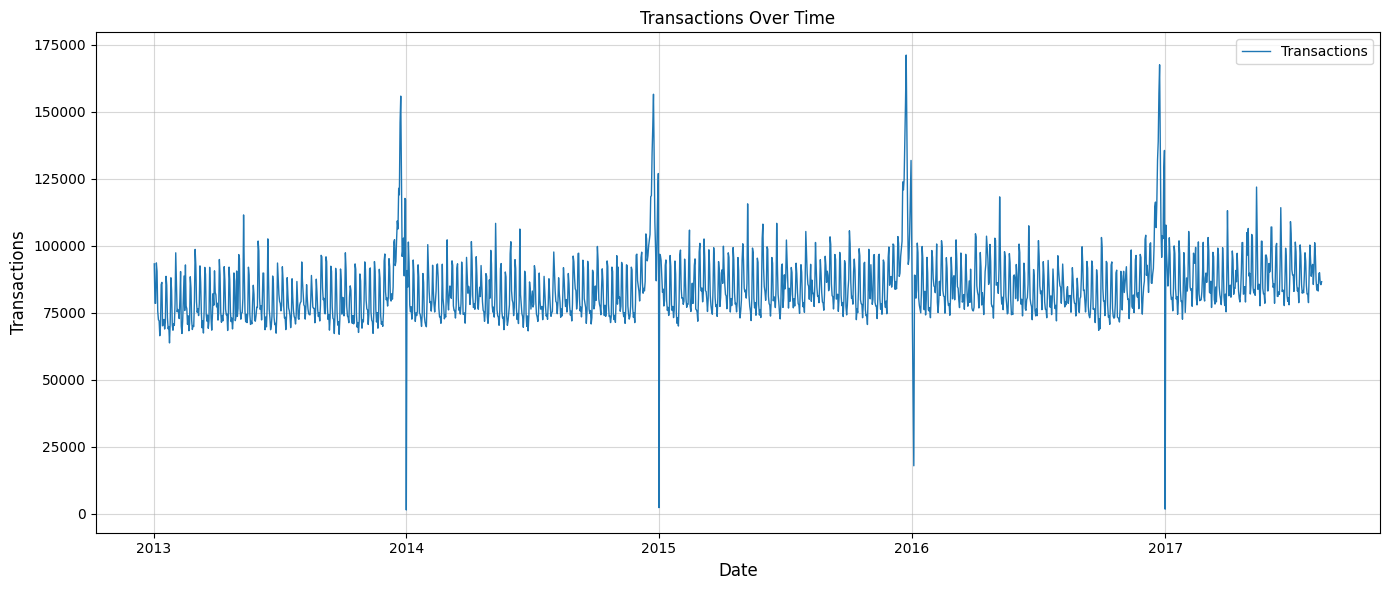

In [7]:
#Ploting the dataframe
plt.figure(figsize=(14,6))
plt.plot(group_sales["date"],group_sales["transactions"],label="Transactions",linewidth=1)
plt.title("Transactions Over Time", fontsize=12)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Transactions",fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()